In [42]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import pickle
from scipy.optimize import curve_fit
from calendar import monthrange

from utils import downloadData
from utils import dataProc
from utils import generateWeb
from utils import generateDB



In [2]:
#Using Pickle to save time during data loading
read = 0
if read:
    data = dataProc.dataProc()
    df = data.loadData()
    df_dict = data.cleanData(df)
    with open('df_dict.pickle', 'wb') as handle:
        pickle.dump(df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_dict.pickle', 'rb') as handle:
    df_dict = pickle.load(handle)

In [3]:
# Missing step from cleanData
for i in df_dict.keys():
    df_dict[i]=df_dict[i].dropna(axis=1, thresh=5) #delete rows with just nan values
    df_dict[i].columns = df_dict[i].columns.str.replace(' ', '')

In [4]:
def grouping_data(df_dict, column): #extract all production data in a single df 
    df = {}
    for i in df_dict.keys():
        df_temp = df_dict[i].groupby(column).sum() # Grouping as needed
        January =  df_temp.columns.get_loc('enero')# picking the group first month location
        if (i == '2014'):
            df_temp['noviembre'] = 0.0
            df_temp['diciembre'] = 0.0
        df[i] = df_temp.loc[:, 'enero'::]# Assign clean table
    return df

def actual_data(campo, df):
    production = np.array([])
    dates = pd.date_range(f'2000-01-01', periods=0, freq='M')

    #Actual data
    for i in df.keys():
        if campo in df[i].index:
            dates = np.append(dates, pd.date_range(f'{i}-01-01', periods= df[i].loc[campo,:].size, freq='M'))
            production = np.append(production, df[i].loc[campo,:])
    
    max_prod = np.max(production)
    a = np.where(production == max_prod)[0][0]
    t_data  = dates[a::]
    prod_data = production[a::]
    
    return production, dates, max_prod, t_data, prod_data


def rate_arps_hyp(times, Di):
    # Arps, hyperbolic, b = 0.5 
    # Decline rate, D, in hyperbolic is not constant ( D = - 1/q * dq/dt ) but the initial Di can be obtained
    global production, b_arps, max_prod
    t = np.arange(times.size)
    q = max_prod/(1. + b_arps*Di*t)**(1/b_arps)
    return q

def decline_rate(times, Di):
    global b_arps
    t = np.arange(times.size)
    D = Di / (1+b_arps*Di*t)
    return D

Arps equation for Hyperbolic rate:\\

$ q(t) = q_i / (1.0 + b D_i t)^\frac{1}{b}$

In [5]:
#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
df_group = grouping_data(df_dict,'campo')

[28 31 30 31 30 31 31 30 31 30 31 31 28 31 30 31 30 31 31 30 31 30 31 31
 29 31 30 31 30 31 31 30 31 30 31]


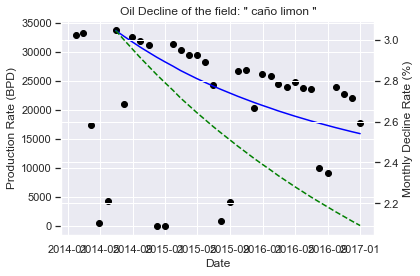

In [84]:
#Selecting field and hyperbolic exponent
campo = "Caño limon"
b_arps = 0.5

campo = campo.lower()
#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(campo, df_group)
#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data, prod_data)

# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil Decline of the field: " {campo} "')

ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(t_data, rate_arps_hyp(t_data, Di_opt),'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data, decline_rate(t_data, Di_opt)*100,'--', color = 'green', label = 'Decline rate')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [7]:
#Using Pickle to save time during data loading
from utils import dataProc
read = 1
if read:
    data = dataProc.dataProc()
    df = data.loadBlindData()
    df_blind = data.cleanBlindData(df)
    with open('df_blind.pickle', 'wb') as handle:
        pickle.dump(df_blind, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('df_blind.pickle', 'rb') as handle:
    df_blind = pickle.load(handle)
df_blind['2019'][df_blind['2019']["campo"]==df_blind['2019']["contrato"]]

Loading data blind test finished
Cleanning blind data
Cleaning blind data finsihed


,departamento,municipio,operadora,contrato,campo,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,cf33cb8a,cf33cb8a,d5580f74,1f-d2689f,1f-d2689f,7897.993261,6687.201142,6176.648164,5998.336864,5838.969170,6390.660871,4766.241346,5871.527810,5179.292397,5928.184630,6237.904951,6226.606211
25,cf33cb8a,5abe4339,ffd6d24d,876a64fe,876a64fe,963.622666,1222.036486,1141.140117,1897.198730,2082.600288,1931.519061,1800.142662,2196.936142,1179.494935,188.011469,349.032107,2163.496657
45,657b6154,28b6a6a0,ffd6d24d,8568d01e,8568d01e,0.000000,0.000000,0.000000,0.000000,303.347789,0.000000,300.107149,281.511533,289.602257,609.261990,446.773277,166.892938


"campo" "1f-d2689f" in "julio - 2019" produced 4766.241346484784 barrels per day


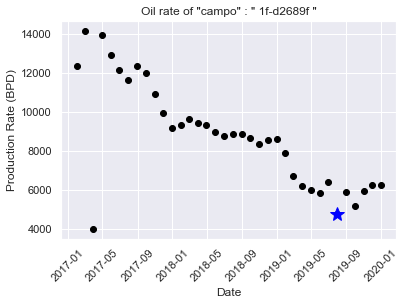

In [109]:
# Question 1 for blind test

#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
criteria = 'campo'
df_group_blind = grouping_data(df_blind,criteria)

index = '1F D2689F'
year = '2019'
month = 'julio'
index = index.lower().replace(" ","-")

report = df_group_blind[year].loc[index,month]

print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels per day')

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)
where = np.where(production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil rate of "{criteria}" : " {index} "')
ax1.plot(dates, production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], production[where],'*', color = 'blue', label = 'Actual data',markersize=15)
plt.show()

"operadora" "2fe52430" in "febrero - 2019" produced 208662.17260608985 barrels


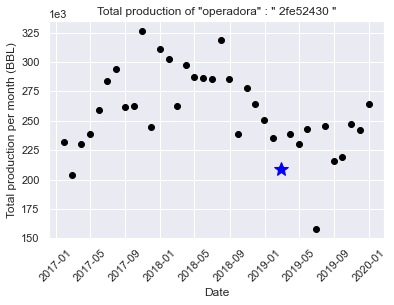

In [102]:
# Question 2 for blind test

#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
criteria = 'operadora'
df_group_blind = grouping_data(df_blind,criteria)
index = '2FE52430'
year = '2019'
month = 'febrero'
index = index.lower().replace(" ","-")

report = df_group_blind[year].loc[index,month] *  monthrange(int(year), 2)[1]

print(f'"{criteria}" "{index}" in "{month} - {year}" produced {report} barrels')

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)

#Calculating the total production per month
dates_month = pd.DatetimeIndex(dates).month
days_per_month = np.array([monthrange(int(year), i)[1] for i in dates_month])
total_production = production*days_per_month

where = np.where(total_production == report)[0][0]

# Plotting data 
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Total production per month (BBL)')
ax1.set_title(f'Total production of "{criteria}" : " {index} "')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(3,3))
ax1.plot(dates, total_production,'o', color = 'black', label = 'Actual data')
ax1.plot(dates[where], total_production[where],'*', color = 'blue', label = 'Actual data',markersize=15)
plt.show()

Total production (barrels) in 2018 by criteria: departamento

[ 3004801.89263314 18970777.53414348  3833958.25357653]


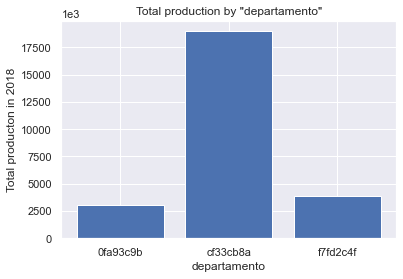

In [113]:
# Question 3 for blind test

#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
criteria = 'departamento'
df_group_blind = grouping_data(df_blind,criteria)
index = '2FE52430'
year = '2018'
month = 'febrero'
index = index.lower().replace(" ","-")


days_per_month = np.array([monthrange(int(year), i)[1] for i in np.arange(1,13)])

report = np.dot(df_group_blind[year].loc[:, :], days_per_month)
conversion = 1
print(f'Total production (barrels) in 2018 by criteria: {criteria}\n')
print(report*conversion)

# Plotting data
fig = plt.figure()
ax1 = plt.axes()
ax1.bar(df_group_blind[year].index, report)
ax1.set_xlabel(criteria)
ax1.set_ylabel(f'Total producton in {year}')
ax1.set_title(f'Total production by "{criteria}"')
ax1.ticklabel_format(axis='y', style='sci',scilimits=(3,3))

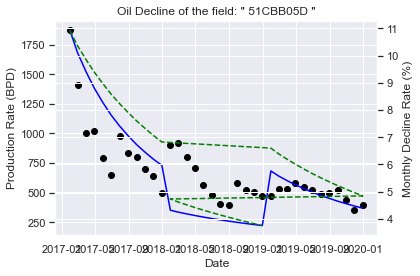

In [115]:
# Question 5 for blind test

#Selecting hyperbolic exponent
b_arps = 0.5

#Grouping data from a particular dictionary of data. Generalizing to handle the blind test
criteria = 'campo'
df_group_blind = grouping_data(df_blind,criteria)
index = "51CBB05D"
index = index.lower().replace(" ","-")

#Getting actual production data
production, dates, max_prod, t_data, prod_data = actual_data(index, df_group_blind)
#Optimizing decline rate
Di_opt, Di_cov = curve_fit(rate_arps_hyp, t_data, prod_data)

#Sorting production as dates are not in order 
i = np.argsort(dates)
i2 = np.argsort(t_data)
# Plotting data and fit
fig = plt.figure()
ax1 = plt.axes()
ax1.set_xlabel('Date')
ax1.set_ylabel('Production Rate (BPD)')
ax1.set_title(f'Oil Decline of the field: " {campo} "')

ax1.plot(dates[i], production[i],'o', color = 'black', label = 'Actual data')
ax1.plot(t_data[i2], rate_arps_hyp(t_data, Di_opt)[i2],'-', color = 'blue', label = 'Arps')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Monthly Decline Rate (%)')
ax2.plot(t_data, decline_rate(t_data, Di_opt)*100,'--', color = 'green', label = 'Decline rate')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()